In [6]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers



In [7]:
# 베이스라인 모델 -> 위 모델을 기준으로, recall값을 평가하는 메트릭을 작성하는 실습을 진행할 것이다.
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.6850 - loss: 0.6128 - val_accuracy: 0.8521 - val_loss: 0.4287
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8872 - loss: 0.3697 - val_accuracy: 0.8816 - val_loss: 0.3275
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9222 - loss: 0.2583 - val_accuracy: 0.8806 - val_loss: 0.2991
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9295 - loss: 0.2115 - val_accuracy: 0.8901 - val_loss: 0.2782
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9476 - loss: 0.1671 - val_accuracy: 0.8805 - val_loss: 0.2951
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9545 - loss: 0.1414 - val_accuracy: 0.8852 - val_loss: 0.2895
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9611 - loss: 0.1261 - val_accuracy: 0.8846 - val_loss: 0.3010
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9733 - loss: 0.1001 - val_accuracy: 0.8798 - v

In [ ]:
# 참고 RMSE 사용자정의 지표 코드
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)


In [8]:
from tensorflow.keras import metrics

class Recall(tf.keras.metrics.Metric):

    def __init__(self, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.TP = self.add_weight(name="True_Positives", initializer="zeros") #TP값 저장 변수, initializer : 초기값 0으로 설정
        self.FN = self.add_weight(name="False_Negatives", initializer="zeros") #FN값 저장 변수


    def update_state(self, y_true, y_pred, sample_weight=None):
        # 확률값을 -> 이진화 하기 (threshold = 0.5)
        # 추가실험 (데이터 분포 살펴본 뒤 threshold 변경 가능)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32) #tf.greater: 예측값이 0.5이상이면 True 아니면 False (Boolean 반환)
        y_true = tf.cast(y_true, tf.float32)                  #tf.cast : 이진화된 값 타입 변환

        # TP 및 FN 계산
        TP = tf.reduce_sum(y_true * y_pred) #TP 샘플 수 확인 true=[1,0,1] pred=[1,1,1] -> TP=[1,0,1] 2개 샘플
        FN = tf.reduce_sum(y_true * (1 - y_pred)) #FN 샘플 수 확인

        # 변수 업데이트 (각 에폭또는 배치에서 새롭게 계산된 TP, FN값 추가)
        self.TP.assign_add(TP) #assign_add : 기존 값에 새로운 값을 더해 상태변수 업데이트
        self.FN.assign_add(FN)


    def result(self):
        # recall 계산 : TP / (TP + FN)
        recall = self.TP / (self.TP + self.FN + tf.keras.backend.epsilon()) #tf.keras.backend.epsilon() : 분모가 0이 되는것을 방지하기 위함
        return recall

    def reset_states(self):
        # TP FN 상태변수 초기화(각 에폭, 평가단계)
        self.TP.assign(0.0)
        self.FN.assign(0.0)

In [11]:
# 모델을 통해 평가지표 추출하기
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=[Recall()])

history_original2 = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.6111 - recall: 0.6249 - val_loss: 0.4081 - val_recall: 0.4616
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.3523 - recall: 0.5102 - val_loss: 0.3189 - val_recall: 0.4805
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2533 - recall: 0.5012 - val_loss: 0.2841 - val_recall: 0.5061
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1937 - recall: 0.5059 - val_loss: 0.2917 - val_recall: 0.4539
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1652 - recall: 0.5075 - val_loss: 0.2825 - val_recall: 0.5351
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1414 - recall: 0.5094 - val_loss: 0.2937 - val_recall: 0.5429
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1215 - recall: 0.5068 - val_loss: 0.3093 - val_recall: 0.4596
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1051 - recall: 0.5022 - val_loss: 0.3068 - val_recall: 0.4890
Epoch 9/20
30/30

In [12]:
# 평가
results = model.evaluate(train_data, train_labels)
print("Evaluation Results:", results)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0631 - recall: 0.5169
Evaluation Results: [0.2272045761346817, 0.5080469250679016]


양성 데이터: 12500 (50.00%)
음성 데이터: 12500 (50.00%)


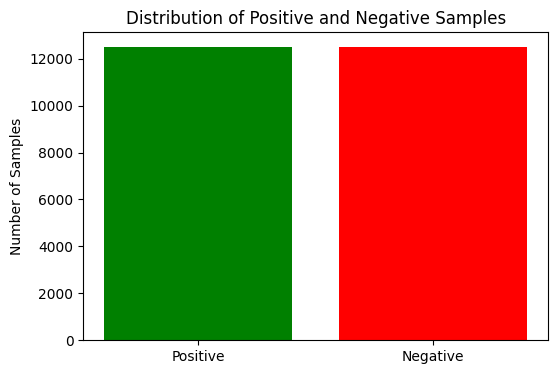

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 양성 및 음성 데이터 개수 확인
positive_count = np.sum(train_labels)  # 레이블 =1 인 샘플 수
negative_count = len(train_labels) - positive_count  # 전체 샘플 - 양성샘플 수

# 총 데이터 개수 및 비율 계산
total_count = len(train_labels)
positive_ratio = positive_count / total_count
negative_ratio = negative_count / total_count

# 출력
print(f"양성 데이터: {positive_count} ({positive_ratio:.2%})")
print(f"음성 데이터: {negative_count} ({negative_ratio:.2%})")

# 데이터 시각화
labels = ['Positive', 'Negative']
counts = [positive_count, negative_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['green', 'red'])
plt.title('Distribution of Positive and Negative Samples')
plt.ylabel('Number of Samples')
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


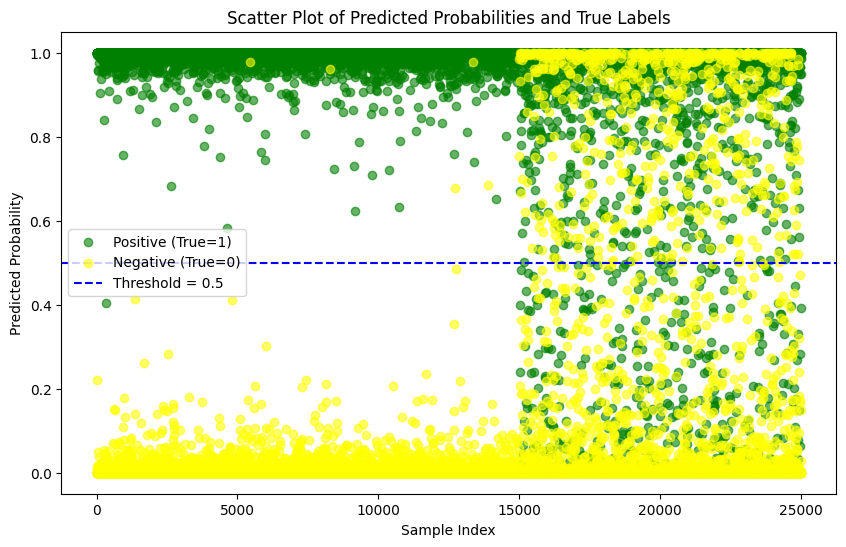

In [22]:
# 데이터의 분포 확인

# 모델 예측 확률값 가져오기
y_pred_probs = model.predict(train_data)

# 시각화: 실제 레이블과 예측 확률
plt.figure(figsize=(10, 6))

# 양성 클래스 (y_true=1)와 음성 클래스 (y_true=0)를 다른 색으로 표시
plt.scatter(np.arange(len(train_labels))[train_labels == 1], y_pred_probs[train_labels == 1],
            color='green', alpha=0.6, label='Positive (True=1)')
plt.scatter(np.arange(len(train_labels))[train_labels == 0], y_pred_probs[train_labels == 0],
            color='yellow', alpha=0.6, label='Negative (True=0)')

# Threshold 라인 추가
threshold = 0.5
plt.axhline(y=threshold, color='blue', linestyle='--', label=f'Threshold = {threshold}')

# 그래프 설정
plt.title('Scatter Plot of Predicted Probabilities and True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras import metrics

#threshold 0.6 변경
class Recall(tf.keras.metrics.Metric):

    def __init__(self, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.TP = self.add_weight(name="True_Positives", initializer="zeros") #TP값 저장 변수, initializer : 초기값 0으로 설정
        self.FN = self.add_weight(name="False_Negatives", initializer="zeros") #FN값 저장 변수


    def update_state(self, y_true, y_pred, sample_weight=None):
        # 확률값을 -> 이진화 하기 (threshold = 0.6)
        # 추가실험 (데이터 분포 살펴본 뒤 threshold 변경 가능)
        y_pred = tf.cast(tf.greater(y_pred, 0.6), tf.float32)          #tf.greater: 예측값이 0.5이상이면 True 아니면 False (Boolean 반환)
        y_true = tf.cast(y_true, tf.float32)                        #tf.cast : 이진화된 값 타입 변환

        # TP 및 FN 계산
        TP = tf.reduce_sum(y_true * y_pred) #TP 샘플 수 확인 true=[1,0,1] pred=[1,1,1] -> TP=[1,0,1] 2개 샘플
        FN = tf.reduce_sum(y_true * (1 - y_pred)) #FN 샘플 수 확인

        # 변수 업데이트 (각 에폭또는 배치에서 새롭게 계산된 TP, FN값 추가)
        self.TP.assign_add(TP) #assign_add : 기존 값에 새로운 값을 더해 상태변수 업데이트
        self.FN.assign_add(FN)


    def result(self):
        # recall 계산 : TP / (TP + FN)
        recall = self.TP / (self.TP + self.FN + tf.keras.backend.epsilon()) #tf.keras.backend.epsilon() : 분모가 0이 되는것을 방지하기 위함
        return recall

    def reset_states(self):
        # TP FN 상태변수 초기화(각 에폭, 평가단계)
        self.TP.assign(0.0)
        self.FN.assign(0.0)

In [16]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=[Recall()])

history_original2 = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.6082 - recall: 0.2248 - val_loss: 0.4104 - val_recall: 0.3289
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.3419 - recall: 0.4386 - val_loss: 0.3066 - val_recall: 0.4484
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.2388 - recall: 0.4606 - val_loss: 0.2818 - val_recall: 0.4508
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1905 - recall: 0.4647 - val_loss: 0.3651 - val_recall: 0.3483
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1670 - recall: 0.4762 - val_loss: 0.2788 - val_recall: 0.4640
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1344 - recall: 0.4878 - val_loss: 0.2887 - val_recall: 0.4617
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1141 - recall: 0.4909 - val_loss: 0.2996 - val_recall: 0.4796
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0981 - recall: 0.4900 - val_loss: 0.3351 - val_recall: 0.5250
Epoch 9/20
30/30

In [26]:
from tensorflow.keras import metrics

#threshold 0.4 변경
class Recall(tf.keras.metrics.Metric):

    def __init__(self, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.TP = self.add_weight(name="True_Positives", initializer="zeros") #TP값 저장 변수, initializer : 초기값 0으로 설정
        self.FN = self.add_weight(name="False_Negatives", initializer="zeros") #FN값 저장 변수


    def update_state(self, y_true, y_pred, sample_weight=None):
        # 확률값을 -> 이진화 하기 (threshold = 0.3)
        # 추가실험 (데이터 분포 살펴본 뒤 threshold 변경 가능)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)     #tf.greater: 예측값이 0.5이상이면 True 아니면 False (Boolean 반환)
        y_true = tf.cast(y_true, tf.float32)                      #tf.cast : 이진화된 값 타입 변환

        # TP 및 FN 계산
        TP = tf.reduce_sum(y_true * y_pred) #TP 샘플 수 확인 true=[1,0,1] pred=[1,1,1] -> TP=[1,0,1] 2개 샘플
        FN = tf.reduce_sum(y_true * (1 - y_pred)) #FN 샘플 수 확인

        # 변수 업데이트 (각 에폭또는 배치에서 새롭게 계산된 TP, FN값 추가)
        self.TP.assign_add(TP) #assign_add : 기존 값에 새로운 값을 더해 상태변수 업데이트
        self.FN.assign_add(FN)


    def result(self):
        # recall 계산 : TP / (TP + FN)
        recall = self.TP / (self.TP + self.FN + tf.keras.backend.epsilon()) #tf.keras.backend.epsilon() : 분모가 0이 되는것을 방지하기 위함
        return recall

    def reset_states(self):
        # TP FN 상태변수 초기화(각 에폭, 평가단계)
        self.TP.assign(0.0)
        self.FN.assign(0.0)

In [27]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=[Recall()])

history_original2 = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.6061 - recall: 0.3709 - val_loss: 0.4141 - val_recall: 0.4308
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.3513 - recall: 0.4922 - val_loss: 0.3261 - val_recall: 0.4514
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.2502 - recall: 0.5011 - val_loss: 0.3025 - val_recall: 0.4434
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1996 - recall: 0.4956 - val_loss: 0.2840 - val_recall: 0.5464
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1691 - recall: 0.5146 - val_loss: 0.2842 - val_recall: 0.5407
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1430 - recall: 0.5071 - val_loss: 0.2857 - val_recall: 0.4846
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1284 - recall: 0.5073 - val_loss: 0.2945 - val_recall: 0.4887
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1048 - recall: 0.5026 - val_loss: 0.3086 - val_recall: 0.4877
Epoch 9/20
30/30

In [28]:
# 사이킷런 Recall rkqt
from sklearn.metrics import recall_score
import numpy as np

# 예측값 가져오기 (확률 값으로 출력)
y_pred_probs = model.predict(train_data)

# 확률 값을 이진화하여 클래스 레이블로 변환 (기본 threshold = 0.5)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()  # 0 또는 1로 변환

# 실제 레이블 가져오기
y_true_labels = train_labels

# 사이킷런의 recall_score로 Recall 계산
recall = recall_score(y_true_labels, y_pred_labels)

print("Recall:", recall)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Recall: 0.93896


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9609 - loss: 0.1511 - recall: 0.5176 - val_accuracy: 0.8738 - val_loss: 0.3692 - val_recall: 0.5410
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9832 - loss: 0.0580 - recall: 0.5299 - val_accuracy: 0.8762 - val_loss: 0.4698 - val_recall: 0.5418
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9924 - loss: 0.0285 - recall: 0.5131 - val_accuracy: 0.8676 - val_loss: 0.5666 - val_recall: 0.5454
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9979 - loss: 0.0135 - recall: 0.5098 - val_accuracy: 0.8666 - val_loss: 0.6657 - val_recall: 0.5085
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9991 - loss: 0.0069 - recall: 0.5086 - val_accuracy: 0.8698 - val_loss: 0.8229 - val_recall: 0.5444
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9994 - loss: 0.0041 - recall: 0.5092 - val_accuracy: 0.8670 - val_loss: 0.8694 - val_recall: 0.5217
Epoc

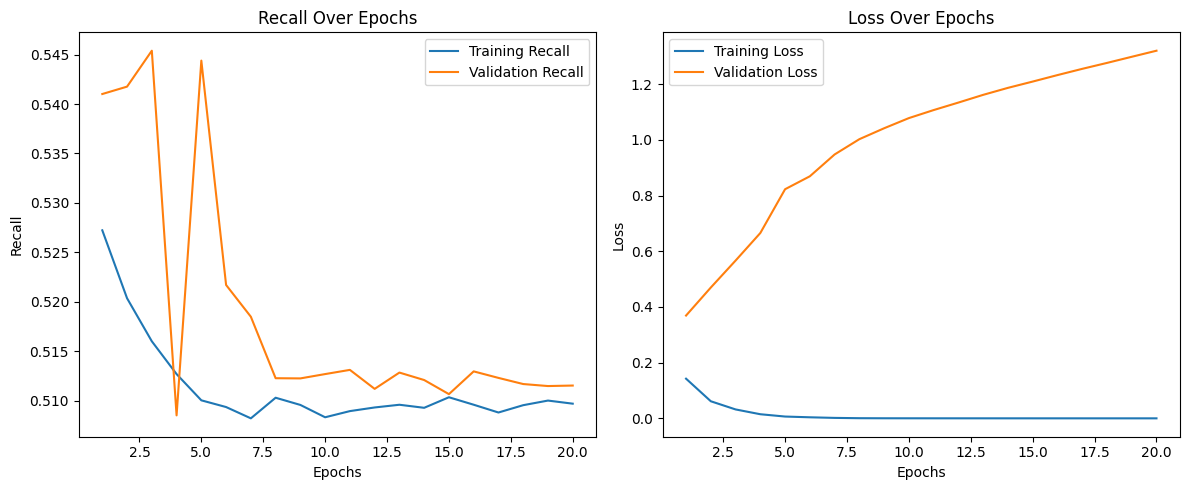

In [23]:
# Recall 사용자 정의 메트릭 포함
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", Recall()]  # 사용자 정의 Recall 메트릭 사용
)

# 모델 훈련
history = model.fit(
    train_data, train_labels,
    validation_split=0.2,
    epochs=20,
    batch_size=64
)

# 결과 시각화
import matplotlib.pyplot as plt

# Recall 및 Accuracy 변화 시각화
epochs = range(1, len(history.history['recall']) + 1)

plt.figure(figsize=(12, 5))

# Recall
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['recall'], label='Training Recall')
plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
plt.title('Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()